In [1]:
import os
import ps4_implementation as imp 
import numpy as np
import itertools as it
import time
import pylab as pl
import random
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from tqdm import tqdm
import sklearn.svm
from copy import deepcopy

In [2]:
 def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.mean(abs(y_pred-y_true))
    #loss = np.sum(np.sum((y_pred-y_true)**2)**0.5, axis = 1) / len(y_pred)
    return loss

In [3]:
def zero_one_loss(y_true, y_pred):
    '''
    Applies a the zero one loss function to predictions.

    Input:
    y_true = the true data labels (nx1)
    y_pred = the predicted data labels (nx1)

    Output:
    loss = the zero one loss
    '''
    loss = np.count_nonzero(y_true != np.sign(y_pred))
    return loss


In [28]:
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    method.params = None
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train,:]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = np.sign(model.predict(X[part[j].astype('int')]))
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(e))
        if e < method.cvloss:
            print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.params = parameter
    #print(method.params)
    model = method(method.params[0],method.params[1],method.params[2])
    model.fit(X,y)
    method = model
    return method

In [79]:
class ASSIGNMENT4():
    def __init__(self):
        DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),"data/easy_2d.npz")
        assert os.path.exists(DATA_PATH), "The path does not excist."
        data = np.load(DATA_PATH)
        print(data.files)
        self.X_tr = data['X_tr'].T
        self.Y_tr = data['Y_tr'].T
        self.X_te = data['X_te'].T
        self.Y_te = data['Y_te'].T
        plt.scatter(self.X_tr[self.Y_tr == -1,0], self.X_tr[self.Y_tr == -1,1], marker = 'x', color = 'r', label = 'Negative -1')
        plt.scatter(self.X_tr[self.Y_tr == 1,0], self.X_tr[self.Y_tr == 1,1], marker = 'o', color = 'b',label = 'Positive +1')
    def find_opti_parameters(self):
        params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-5,3, 50), 'regularization': np.logspace(-2,3, 10) }
        self.cvsvm = cv(self.X_tr, self.Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
        self.params = self.cvsvm.params
        print("paramters found: {}".format(self.cvsvm.params))
        print("accuracy: {}".format(np.sum(np.sign(self.cvsvm.predict(self.X_te)) == self.Y_te)/ len(self.X_te)))
        imp.plot_boundary_2d(self.X_tr, self.Y_tr, self.cvsvm)
    def find_over_parameters(self):
        params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-5,3, 50), 'regularization': [10**14]}#np.logspace(13,16, 4) }
        self.cvsvm = cv(self.X_tr, self.Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
        print("paramters found: {}".format(self.cvsvm.params))
        imp.plot_boundary_2d(self.X_tr, self.Y_tr, self.cvsvm)
    def find_under_parameters(self):
        params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-7,-4, 50), 'regularization': [1]}#np.logspace(1,10, 10) }
        self.cvsvm = cv(self.X_tr, self.Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
        print("paramters found: {}".format(self.cvsvm.params))
        imp.plot_boundary_2d(self.X_tr, self.Y_tr, self.cvsvm)
    def ROC(self):
        print("find optimal parameters")
        self.cvsvm = self.find_opti_parameters()
        print("now create ROC curve")
        tpr = [np.zeros(1)]
        fpr = [np.zeros(1)]
        threshold = 0
        pos_label=-1
        neg = np.sum(np.array(self.Y_te.flatten() == -1))
        pos = len(self.Y_te) - neg
        #y_true=(y_true==pos_label) #boolean vec of true labels
        model = imp.svm_qp(self.params[0],self.params[1],self.params[2])
        model.fit(self.X_tr,self.Y_tr)
        y_pred = model.predict(self.X_te)
        biases = y_pred
        # Use test predictions as bias 
        #biases = np.linspace(-1,4,200)
        for bias in biases:
            prediction = y_pred.T + bias > threshold
            tpr.append(prediction[self.Y_te == 1].sum(axis=0) / pos)
            fpr.append(prediction[self.Y_te == -1, :].sum(axis=0) / neg)
        fpr = np.concatenate(fpr)
        tpr = np.concatenate(tpr)
        idx = np.argsort(fpr) # sort by fpr in increasing order
        fpr = fpr[idx]
        tpr = tpr[idx]
        plt.plot(fpr,tpr,label='SVM')
        plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label='Random guesses')
        plt.ylabel('True Positive Rate (TPR)')
        plt.xlabel('False Positive Rate (FPR)')
        plt.title('ROC Curve')
        plt.legend()
    

In [106]:
class ASSIGNMENT5():
    def __init__(self):
        # Load data for #5
        DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),"data/iris.npz")
        assert os.path.exists(DATA_PATH), "The path does not excist."
        data = np.load(DATA_PATH)
        print(data.files)
        self.X = data['X'].T
        self.Y = data['Y'].T
        print("Shape of X: {}".format(self.X.shape))
        print("Shape of Y: {}".format(self.Y.shape))
        # train test split
        test_size = 1/3
        idx = np.linspace(0,len(self.X)-1,len(self.X)).astype(int)
        random.shuffle(idx)
        self.X_tr = self.X[idx[:int((1-test_size)*len(self.X))],:]
        self.X_te = self.X[idx[int((1-test_size)*len(self.X)):],:]
        self.y_tr = self.Y[idx[:int((1-test_size)*len(self.X))]]
        self.y_te = self.Y[idx[int((1-test_size)*len(self.X)):]]
    def visualize_data(self):
        fig, axs = plt.subplots(2, 2)
        axs[0, 0].scatter(self.X[self.Y == 1,0], self.X[self.Y == 1,1], marker = 'o', color = 'r', label = 'setosa')
        axs[0, 0].scatter(self.X[self.Y == 2,0], self.X[self.Y == 2,1], marker = 'o', color = 'b',label = 'versicolor')
        axs[0, 0].scatter(self.X[self.Y == 3,0], self.X[self.Y == 3,1], marker = 'o', color = 'g',label = 'virginica')
        axs[0, 1].scatter(self.X[self.Y == 1,2], self.X[self.Y == 1,1], marker = 'o', color = 'r', label = 'setosa')
        axs[0, 1].scatter(self.X[self.Y == 2,2], self.X[self.Y == 2,1], marker = 'o', color = 'b',label = 'versicolor')
        axs[0, 1].scatter(self.X[self.Y == 3,2], self.X[self.Y == 3,1], marker = 'o', color = 'g',label = 'virginica')
        axs[1, 0].scatter(self.X[self.Y == 1,0], self.X[self.Y == 1,3], marker = 'o', color = 'r', label = 'setosa')
        axs[1, 0].scatter(self.X[self.Y == 2,0], self.X[self.Y == 2,3], marker = 'o', color = 'b',label = 'versicolor')
        axs[1, 0].scatter(self.X[self.Y == 3,0], self.X[self.Y == 3,3], marker = 'o', color = 'g',label = 'virginica')
        axs[1, 1].scatter(self.X[self.Y == 1,2], self.X[self.Y == 1,3], marker = 'o', color = 'r', label = 'setosa')
        axs[1, 1].scatter(self.X[self.Y == 2,2], self.X[self.Y == 2,3], marker = 'o', color = 'b',label = 'versicolor')
        axs[1, 1].scatter(self.X[self.Y == 3,2], self.X[self.Y == 3,3], marker = 'o', color = 'g',label = 'virginica')

        axs[0, 0].set(ylabel = 'sepal width')
        axs[1, 0].set(xlabel = 'sepal length')
        axs[1, 0].set(ylabel = 'petal width')
        axs[1, 1].set(xlabel = 'petal length')
    def linear_hard_svm(self):
        accuracy = []
        for target in np.unique(self.Y):
            # relabel class data into 1 and -1
            # target is 1, rest -1
            y_tr_r = deepcopy(self.y_tr)
            y_tr_r[np.where(y_tr_r != target)] = -1
            y_tr_r[y_tr_r == target] = 1
            y_te_r = deepcopy(self.y_te)
            y_te_r[np.where(y_te_r != target)] = -1   
            y_te_r[y_te_r == target] = 1
    
                # SVM with hard-margin
            params = { 'kernel': ['linear'], 'kernelparameter': [1], 'regularization': [None]}#np.logspace(-2,4, 200)*len(y_tr_r) }
            cvsvm = cv(self.X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
            print('Target class: {}'.format(target))
            print('Loss: {}'.format(cvsvm.cvloss))
            print('Parameters: {}'.format(cvsvm.params))
            accuracy.append(np.sum(np.sign(cvsvm.predict(self.X_te)) == y_te_r) / len(y_te_r))
        print('accuracy: {}'.format(accuracy))
    def gaussian_hard_svm(self):
    # gaussian kernel
    # hard margin
        accuracy = []
        for target in np.unique(self.Y):
            # relabel class data into 1 and -1
            # target is 1, rest -1
            y_tr_r = deepcopy(self.y_tr)
            y_tr_r[np.where(y_tr_r != target)] = -1
            y_tr_r[y_tr_r == target] = 1
            y_te_r = deepcopy(self.y_te)
            y_te_r[np.where(y_te_r != target)] = -1
            y_te_r[y_te_r == target] = 1
    
            # SVM with hard-margin
            params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,5,100), 'regularization': [None] }
            cvsvm = cv(self.X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
            print('Target class: {}'.format(target))
            print('Loss: {}'.format(cvsvm.cvloss))
            print('Parameters: {}'.format(cvsvm.params))
            accuracy.append(np.sum(np.sign(cvsvm.predict(self.X_te)) == y_te_r) / len(y_te_r))
        print('accuracy: {}'.format(accuracy))
    def polynomial_hard_svm(self):
        # polynomial kernel
        # hard margin
        accuracy = []
        for target in np.unique(self.Y):
            # relabel class data into 1 and -1
            # target is 1, rest -1
            y_tr_r = deepcopy(self.y_tr)
            y_tr_r[np.where(y_tr_r != target)] = -1
            y_tr_r[y_tr_r == target] = 1
            y_te_r = deepcopy(self.y_te)
            y_te_r[np.where(y_te_r != target)] = -1
            y_te_r[y_te_r == target] = 1
    
            # SVM with hard-margin
            params = { 'kernel': ['polynomial'], 'kernelparameter': np.logspace(-2,1,25), 'regularization': [None] }
            cvsvm = cv(self.X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
            print('Target class: {}'.format(target))
            print('Loss: {}'.format(cvsvm.cvloss))
            print('Parameters: {}'.format(cvsvm.params))
            accuracy.append(np.sum(np.sign(cvsvm.predict(self.X_te)) == y_te_r) / len(y_te_r))
        print('accuracy: {}'.format(accuracy))

In [107]:
test = ASSIGNMENT5()

['Y', 'X']
Shape of X: (135, 4)
Shape of Y: (135,)


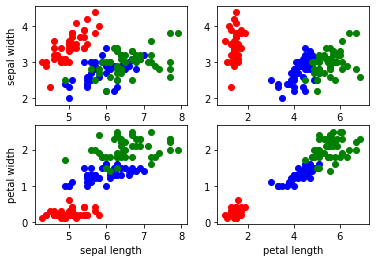

In [100]:
test.visualize_data()

In [108]:
test.polynomial_hard_svm()

 12%|█▏        | 3/25 [00:00<00:03,  6.55it/s]

0.0


 80%|████████  | 20/25 [00:01<00:00, 11.03it/s]/Users/leo/anaconda3/envs/Python37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leo/anaconda3/envs/Python37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 1/25 [00:00<00:02,  9.97it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('polynomial', 0.01, None)
6.0


 76%|███████▌  | 19/25 [00:01<00:00, 13.30it/s]

0.92
0.72


  4%|▍         | 1/25 [00:00<00:04,  5.72it/s]

Target class: 2.0
Loss: 0.72
Parameters: ('polynomial', 2.371373705661655, None)
0.88


 16%|█▌        | 4/25 [00:00<00:03,  6.19it/s]

0.64
0.6


 68%|██████▊   | 17/25 [00:02<00:00,  8.58it/s]

0.52


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]

Target class: 3.0
Loss: 0.52
Parameters: ('polynomial', 0.7498942093324559, None)
accuracy: [1.0, 0.9555555555555556, 0.9555555555555556]


 40%|████      | 2/5 [00:00<00:00,  6.37it/s]

11.6


 80%|████████  | 4/5 [00:00<00:00,  6.83it/s]

11.28


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


paramters found: ('gaussian', 3.162277660168379e-06, 1)


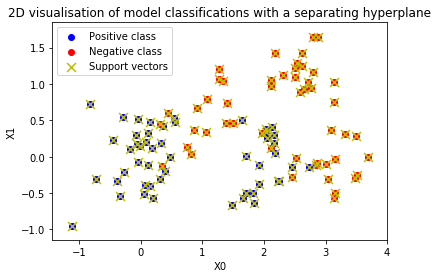

In [51]:
test.find_under_parameters()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/leo/anaconda3/envs/Python37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leo/anaconda3/envs/Python37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 1/50 [00:00<00:08,  5.94it/s]

find optimal parameters
13.76


  6%|▌         | 3/50 [00:00<00:07,  6.53it/s]

11.68


 14%|█▍        | 7/50 [00:00<00:05,  8.09it/s]

11.44


 40%|████      | 20/50 [00:02<00:02, 10.24it/s]

11.36
11.28


 46%|████▌     | 23/50 [00:02<00:03,  8.39it/s]

10.28


 54%|█████▍    | 27/50 [00:03<00:03,  7.50it/s]

7.28


 58%|█████▊    | 29/50 [00:03<00:02,  7.04it/s]

4.6


 82%|████████▏ | 41/50 [00:05<00:01,  7.75it/s]

4.28


100%|██████████| 50/50 [00:06<00:00,  7.85it/s]


paramters found: ('gaussian', 10.0, 1000.0)
accuracy: 0.85


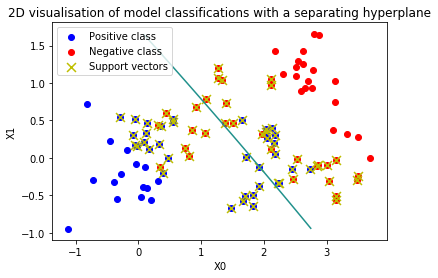

now create ROC curve


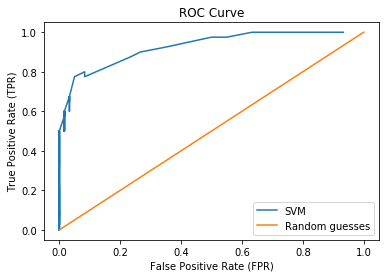

In [81]:
test.ROC()

In [17]:
np.sum(Y_tr == 1)

50

In [39]:
X_tr = data['X_tr'].T
Y_tr = data['Y_tr'].T
X_te = data['X_te'].T
Y_te = data['Y_te'].T

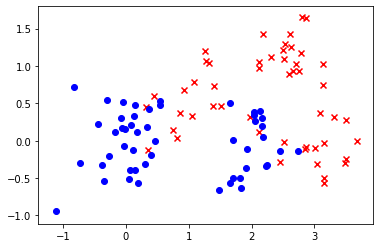

In [40]:
# Visualize data
plt.scatter(X_tr[Y_tr == -1,0], X_tr[Y_tr == -1,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(X_tr[Y_tr == 1,0], X_tr[Y_tr == 1,1], marker = 'o', color = 'b',label = 'Positive +1')
#plt.scatter(X_te[Y_te == -1,0], X_te[Y_te == -1,1], marker = 'x', color = 'g', label = 'Negative -1')
#plt.scatter(X_te[Y_te == 1,0], X_te[Y_te == 1,1], marker = 'o', color = 'g',label = 'Positive +1')

In [47]:
# Fivefold Cross validation
# identify suitable gaussian kernels 
#D = imp.sqdistmat(X_tr)
#quantiles = np.quantile(D,[0.1,0.5, 0.9])
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-5,3, 50), 'regularization': np.logspace(-2,3, 10) }
cvsvm = cv(X_tr, Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)


  0%|          | 2/500 [00:00<01:13,  6.74it/s]

12.48
11.44


  2%|▏         | 11/500 [00:01<00:58,  8.43it/s]

11.12


  4%|▍         | 21/500 [00:02<00:48,  9.92it/s]

11.04


 38%|███▊      | 188/500 [00:19<00:27, 11.27it/s]

10.96


 42%|████▏     | 209/500 [00:21<00:29,  9.96it/s]

10.84


 44%|████▍     | 219/500 [00:22<00:34,  8.23it/s]

9.96


 46%|████▌     | 230/500 [00:24<00:36,  7.48it/s]

8.76


 48%|████▊     | 239/500 [00:25<00:33,  7.77it/s]

7.4
7.32


 48%|████▊     | 241/500 [00:25<00:34,  7.46it/s]

6.8


 50%|████▉     | 249/500 [00:27<00:45,  5.47it/s]

5.2
5.12


 52%|█████▏    | 259/500 [00:28<00:30,  7.93it/s]

3.92


 53%|█████▎    | 267/500 [00:29<00:29,  7.86it/s]

3.32


 54%|█████▍    | 269/500 [00:30<00:39,  5.88it/s]

3.28


 55%|█████▌    | 277/500 [00:32<00:38,  5.72it/s]

2.84


 56%|█████▌    | 279/500 [00:32<00:32,  6.82it/s]

2.52


 58%|█████▊    | 289/500 [00:33<00:26,  8.06it/s]

2.28


100%|██████████| 500/500 [01:01<00:00,  8.09it/s]


accuracy: 0.92


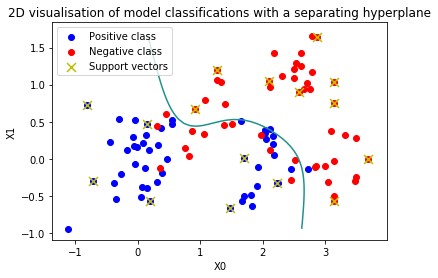

In [45]:
cvsvm.__params
print("accuracy: {}".format(np.sum(np.sign(cvsvm.predict(X_te)) == Y_te)/ len(X_te)))
imp.plot_boundary_2d(X_tr, Y_tr, cvsvm)

92

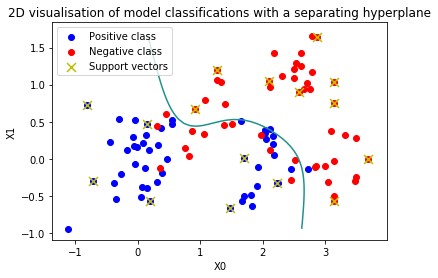

In [46]:
cvsvm.alpha_sv.shape

(16,)

In [19]:
# Sklearn results

# Fivefold Cross validation
# identify suitable gaussian kernels from training data quantiles
D = imp.sqdistmat(X_tr)
quantiles = np.quantile(D,[0.1,0.5, 0.9])
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-5,3, 50), 'regularization': np.logspace(-5,1, 10) }
cvsvm_sk = cv(X_tr, Y_tr, imp.svm_sklearn, params, loss_function=zero_one_loss, nfolds=5)

  1%|          | 3/500 [00:00<00:21, 23.34it/s]

12.32


  4%|▍         | 19/500 [00:00<00:15, 30.34it/s]

12.16


 34%|███▎      | 168/500 [00:04<00:08, 41.46it/s]

11.52


 36%|███▌      | 181/500 [00:04<00:08, 36.63it/s]

11.44
11.32
11.12


 40%|███▉      | 199/500 [00:05<00:07, 38.35it/s]

11.08


 43%|████▎     | 216/500 [00:05<00:07, 38.00it/s]

10.88


 46%|████▋     | 232/500 [00:06<00:08, 31.10it/s]

10.6


 49%|████▉     | 244/500 [00:06<00:08, 28.64it/s]

10.44
9.6


 51%|█████     | 255/500 [00:07<00:08, 29.25it/s]

9.12


 53%|█████▎    | 263/500 [00:07<00:07, 30.13it/s]

7.8
6.96


 55%|█████▌    | 275/500 [00:07<00:07, 30.26it/s]

5.44


 57%|█████▋    | 283/500 [00:08<00:07, 30.31it/s]

5.0
3.96


 59%|█████▉    | 294/500 [00:08<00:07, 29.33it/s]

3.2
3.16


 61%|██████    | 304/500 [00:08<00:07, 27.83it/s]

2.64
2.32


 65%|██████▍   | 324/500 [00:09<00:05, 34.16it/s]

2.08


100%|██████████| 500/500 [00:13<00:00, 35.98it/s]


In [20]:
cvsvm_sk.__params

('gaussian', 1.1513953993264456, 2.154434690031882)

In [21]:
def plot_boundary_2d_sk(X, y, model):
    """
    Plots a 2 dimensional boundary of a model.

    Inputs:
    X = 2d data array (nx2)
    y = labels (nx1)
    model = model (typically SVM or neural net)
    """
    # 1. plot points X
    plt.scatter(X.T[0][np.argwhere(y == 1)], X.T[1][np.argwhere(y == 1)], c='b', label='Positive class')
    plt.scatter(X.T[0][np.argwhere(y == -1)], X.T[1][np.argwhere(y == -1)], c='r', label='Negative class')

    # 2. mark support vectors with a cross if svm
    if isinstance(model, imp.svm_sklearn):
        plt.scatter(model.X_sv.T[0], model.X_sv.T[1], s=80, c='y', marker='x', label='Support vectors')

    # 3. plot separating hyperplane
    # 3a. create grid of predictions
    x_max = np.amax(X, axis=0)
    x_min = np.amin(X, axis=0)
    x0 = np.linspace(x_min[0], x_max[0], 50)
    x1 = np.linspace(x_min[1], x_max[1], 50)
    x0v, x1v = np.meshgrid(x0, x1)
    Xv = np.squeeze(np.array((x0v.reshape(2500, 1), x1v.reshape(2500, 1))))
    grid_pred = model.predict(Xv.T)
    # 3b plot level 0 contour line
    plt.contour(x0, x1, grid_pred.reshape(50, 50), levels=0)

    # format plot
    plt.ylabel('X1')
    plt.xlabel('X0')
    plt.title('2D visualisation of model classifications with a separating hyperplane')
    plt.legend()
    plt.show()

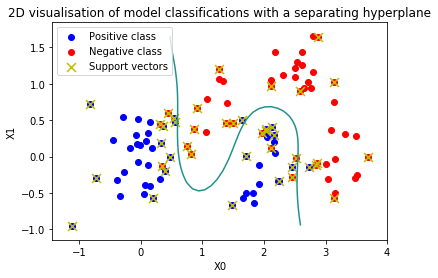

In [22]:
plot_boundary_2d_sk(X_tr, Y_tr, cvsvm_sk)

In [23]:
cvsvm_sk.X_sv.shape

(42, 2)

  2%|▏         | 1/50 [00:00<00:23,  2.11it/s]

11.36


  6%|▌         | 3/50 [00:01<00:20,  2.34it/s]

10.64


 44%|████▍     | 22/50 [00:07<00:10,  2.78it/s]

10.04


 46%|████▌     | 23/50 [00:08<00:10,  2.50it/s]

9.52


 48%|████▊     | 24/50 [00:08<00:10,  2.39it/s]

6.8


 50%|█████     | 25/50 [00:09<00:10,  2.36it/s]

5.48


 52%|█████▏    | 26/50 [00:09<00:10,  2.33it/s]

4.56


 54%|█████▍    | 27/50 [00:09<00:09,  2.32it/s]

4.0


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


('gaussian', 0.17575106248547895, 100000000000000)


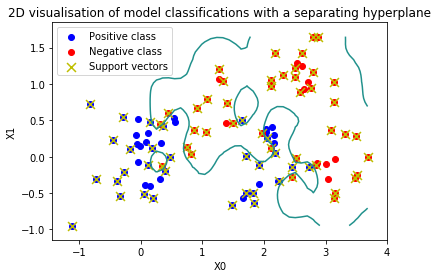

In [31]:
# Produce Overfitting
# Fivefold Cross validation
# identify suitable gaussian kernels from training data quantiles
D = imp.sqdistmat(X_tr)
#quantiles = np.quantile(D,[0.1,0.5, 0.9])
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-5,3, 50), 'regularization': [10**14]}#np.logspace(13,16, 4) }
cvsvm = cv(X_tr, Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
print(cvsvm.__params)
imp.plot_boundary_2d(X_tr, Y_tr, cvsvm)

In [32]:
print(cvsvm.X_sv.shape)
print(cvsvm.cvloss)
print('Number of correct classified test data: {}'.format(np.sum(np.sign(cvsvm.predict(X_te)) == Y_te)))
print('accuracy: {}'.format(np.sum(np.sign(cvsvm.predict(X_te)) == Y_te)/len(X_te)))
print(cvsvm.__params)

(69, 2)
4.0
Number of correct classified test data: 80
accuracy: 0.8
('gaussian', 0.17575106248547895, 100000000000000)


  4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

11.44


 14%|█▍        | 7/50 [00:00<00:05,  8.12it/s]

11.36
11.28


 18%|█▊        | 9/50 [00:01<00:05,  7.49it/s]

11.12


100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


('gaussian', 2.6826957952797275e-07, 1)


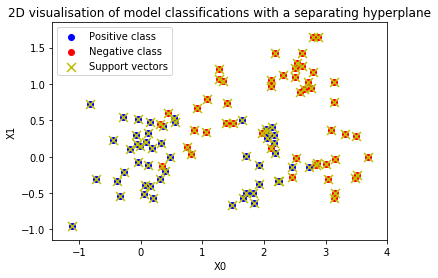

In [35]:
# Produce Underfitting
# Fivefold Cross validation
# identify suitable gaussian kernels from training data quantiles
#D = imp.sqdistmat(X_tr)
#quantiles = np.quantile(D,[0.1,0.5, 0.9])
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-7,-4, 50), 'regularization': [1]}#np.logspace(1,10, 10) }
cvsvm = cv(X_tr, Y_tr, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
print(cvsvm.__params)
imp.plot_boundary_2d(X_tr, Y_tr, cvsvm)

In [37]:
print(cvsvm.X_sv.shape)
print(cvsvm.cvloss)
print('Number of correct classified test data: {}'.format(np.sum(np.sign(cvsvm.predict(X_te)) == Y_te)))
print('accuracy: {}'.format(np.sum(np.sign(cvsvm.predict(X_te)) == Y_te)/len(X_te)))
print(cvsvm.__params)
# everything predicted to class 1

(100, 2)
11.12
Number of correct classified test data: 40
accuracy: 0.4
('gaussian', 2.6826957952797275e-07, 1)


In [38]:
cvsvm.alpha_sv

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [36]:
cvsvm.predict(X_te)

array([[2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.74714043e-06,
        2.74714043e-06, 2.74714043e-06, 2.74714043e-06, 2.747140

Technically, the gamma parameter is the inverse of the standard deviation of the RBF kernel (Gaussian function), which is used as similarity measure between two points. Intuitively, a small gamma value define a Gaussian function with a large variance. In this case, two points can be considered similar even if are far from each other. In the other hand, a large gamma value means define a Gaussian function with a small variance and in this case, two points are considered similar just if they are close to each other.

When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes

In [28]:
# ROC

In [47]:
def ROC (y_true,xtrain,ytrain,xtest,params,method):
    tpr = [np.zeros(1)]
    fpr = [np.zeros(1)]
    threshold = 0
    pos_label=-1
    neg = np.sum(np.array(y_true.flatten() == -1))
    pos = len(y_true) - neg
    #y_true=(y_true==pos_label) #boolean vec of true labels
    model = method(params[0],params[1],params[2])
    model.fit(X_tr,Y_tr)
    y_pred = model.predict(X_te)
    biases = y_pred
    # Use test predictions as bias 
    #biases = np.linspace(-1,4,200)
    for bias in biases:
        prediction = y_pred.T + bias > threshold
        tpr.append(prediction[y_true == 1].sum(axis=0) / pos)
        fpr.append(prediction[y_true == -1, :].sum(axis=0) / neg)
    fpr = np.concatenate(fpr)
    tpr = np.concatenate(tpr)
    idx = np.argsort(fpr) # sort by fpr in increasing order
    fpr = fpr[idx]
    tpr = tpr[idx]
    plt.plot(fpr,tpr,label='SVM')
    plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),label='Random guesses')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.title('ROC Curve')
    plt.legend()


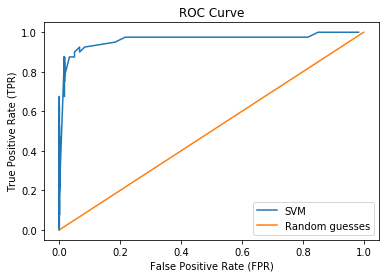

In [54]:
ROC(Y_te,X_tr,Y_tr,X_te,params = cvsvm.__params, method = imp.svm_qp)

In [48]:
cvsvm.__params

('gaussian', 0.3727593720314938, 77.42636826811278)

In [49]:
############# 5

In [117]:
# Load data for #5
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),"data/iris.npz")
assert os.path.exists(DATA_PATH), "The path does not excist."
data = np.load(DATA_PATH)
print(data.files)
X = data['X'].T
Y = data['Y'].T
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))
# train test split
test_size = 1/3
idx = np.linspace(0,len(X)-1,len(X)).astype(int)
random.shuffle(idx)
X_tr = X[idx[:int((1-test_size)*len(X))],:]
X_te = X[idx[int((1-test_size)*len(X)):],:]
y_tr = Y[idx[:int((1-test_size)*len(X))]]
y_te = Y[idx[int((1-test_size)*len(X)):]]

['Y', 'X']
Shape of X: (135, 4)
Shape of Y: (135,)


Text(0, 0.5, 'sepal width')

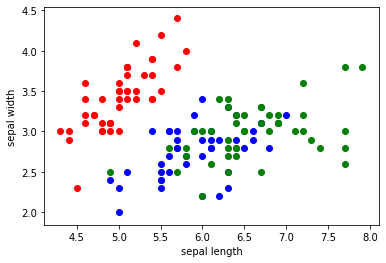

In [95]:
# Visualize data
plt.scatter(X[Y == 1,0], X[Y == 1,1], marker = 'o', color = 'r', label = 'setosa')
plt.scatter(X[Y == 2,0], X[Y == 2,1], marker = 'o', color = 'b',label = 'versicolor')
plt.scatter(X[Y == 3,0], X[Y == 3,1], marker = 'o', color = 'g',label = 'virginica')
plt.xlabel('sepal length')
plt.ylabel('sepal width')

Text(0, 0.5, 'petal width')

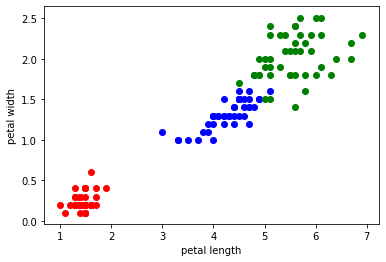

In [397]:
# Visualize data
plt.scatter(X[Y == 1,2], X[Y == 1,3], marker = 'o', color = 'r', label = 'setosa')
plt.scatter(X[Y == 2,2], X[Y == 2,3], marker = 'o', color = 'b',label = 'versicolor')
plt.scatter(X[Y == 3,2], X[Y == 3,3], marker = 'o', color = 'g',label = 'virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')

[Text(0.5, 0, 'petal length')]

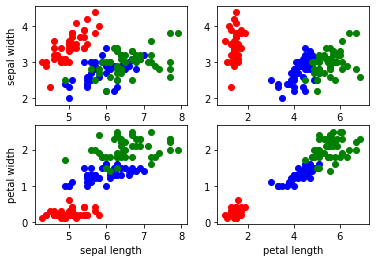

In [83]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(X[Y == 1,0], X[Y == 1,1], marker = 'o', color = 'r', label = 'setosa')
axs[0, 0].scatter(X[Y == 2,0], X[Y == 2,1], marker = 'o', color = 'b',label = 'versicolor')
axs[0, 0].scatter(X[Y == 3,0], X[Y == 3,1], marker = 'o', color = 'g',label = 'virginica')
axs[0, 1].scatter(X[Y == 1,2], X[Y == 1,1], marker = 'o', color = 'r', label = 'setosa')
axs[0, 1].scatter(X[Y == 2,2], X[Y == 2,1], marker = 'o', color = 'b',label = 'versicolor')
axs[0, 1].scatter(X[Y == 3,2], X[Y == 3,1], marker = 'o', color = 'g',label = 'virginica')
axs[1, 0].scatter(X[Y == 1,0], X[Y == 1,3], marker = 'o', color = 'r', label = 'setosa')
axs[1, 0].scatter(X[Y == 2,0], X[Y == 2,3], marker = 'o', color = 'b',label = 'versicolor')
axs[1, 0].scatter(X[Y == 3,0], X[Y == 3,3], marker = 'o', color = 'g',label = 'virginica')
axs[1, 1].scatter(X[Y == 1,2], X[Y == 1,3], marker = 'o', color = 'r', label = 'setosa')
axs[1, 1].scatter(X[Y == 2,2], X[Y == 2,3], marker = 'o', color = 'b',label = 'versicolor')
axs[1, 1].scatter(X[Y == 3,2], X[Y == 3,3], marker = 'o', color = 'g',label = 'virginica')

axs[0, 0].set(ylabel = 'sepal width')
axs[1, 0].set(xlabel = 'sepal length')
axs[1, 0].set(ylabel = 'petal width')
axs[1, 1].set(xlabel = 'petal length')

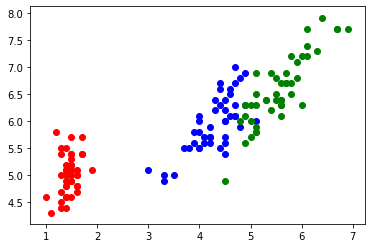

In [84]:
plt.scatter(X[Y == 1,2], X[Y == 1,0], marker = 'o', color = 'r', label = 'setosa')
plt.scatter(X[Y == 2,2], X[Y == 2,0], marker = 'o', color = 'b',label = 'versicolor')
plt.scatter(X[Y == 3,2], X[Y == 3,0], marker = 'o', color = 'g',label = 'virginica')

In [104]:
# linear kernel hard margin
# Hard margin SVM can work only when data is completely linearly separable without any errors (noise or outliers).
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['linear'], 'kernelparameter': [1], 'regularization': [None]}#np.logspace(-2,4, 200)*len(y_tr_r) }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  0%|          | 0/1 [00:00<?, ?it/s]

0.0
Target class: 1.0
Loss: 0.0
Parameters: ('linear', 1, None)
5.8
Target class: 2.0
Loss: 5.8
Parameters: ('linear', 1, None)


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

0.48
Target class: 3.0
Loss: 0.48
Parameters: ('linear', 1, None)
accuracy: [1.0, 0.6444444444444445, 0.9555555555555556]


In [107]:
# gaussian kernel
# hard margin
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,5,100), 'regularization': [None] }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  3%|▎         | 3/100 [00:00<00:09, 10.34it/s]

5.4


 14%|█▍        | 14/100 [00:01<00:07, 11.60it/s]

5.04
4.12


 16%|█▌        | 16/100 [00:01<00:07, 11.56it/s]

3.24
3.12


 20%|██        | 20/100 [00:01<00:07, 11.07it/s]

2.24
1.88
1.36


 22%|██▏       | 22/100 [00:01<00:07, 10.60it/s]

0.68
0.2


 24%|██▍       | 24/100 [00:02<00:07,  9.74it/s]

0.12
0.0


  2%|▏         | 2/100 [00:00<00:06, 14.36it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('gaussian', 0.4229242874389499, None)
5.8


 14%|█▍        | 14/100 [00:01<00:06, 12.37it/s]

5.76
5.52
4.0


 18%|█▊        | 18/100 [00:01<00:06, 13.14it/s]

3.72
2.88
1.84


 20%|██        | 20/100 [00:01<00:06, 12.98it/s]

1.16
0.88


 22%|██▏       | 22/100 [00:01<00:06, 11.28it/s]

0.64
0.52


 35%|███▌      | 35/100 [00:03<00:10,  6.08it/s]

0.36


  2%|▏         | 2/100 [00:00<00:07, 13.37it/s]

Target class: 2.0
Loss: 0.36
Parameters: ('gaussian', 2.154434690031882, None)
6.4


 16%|█▌        | 16/100 [00:01<00:06, 12.51it/s]

6.12
6.0
5.6


 18%|█▊        | 18/100 [00:01<00:08,  9.88it/s]

4.6
4.08


 21%|██        | 21/100 [00:01<00:08,  9.11it/s]

2.92
1.88
1.24


 23%|██▎       | 23/100 [00:02<00:08,  8.71it/s]

0.96


 25%|██▌       | 25/100 [00:02<00:08,  9.01it/s]

0.92


 27%|██▋       | 27/100 [00:02<00:09,  7.97it/s]

0.8


 29%|██▉       | 29/100 [00:02<00:09,  7.78it/s]

0.76
0.72


 34%|███▍      | 34/100 [00:03<00:10,  6.48it/s]

0.6
0.56


 39%|███▉      | 39/100 [00:04<00:09,  6.36it/s]

0.44


 44%|████▍     | 44/100 [00:05<00:09,  6.13it/s]

0.4
0.36


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]

Target class: 3.0
Loss: 0.36
Parameters: ('gaussian', 10.974987654930557, None)
accuracy: [0.9777777777777777, 0.9555555555555556, 0.9555555555555556]


In [113]:
# polynomial kernel
# hard margin
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['polynomial'], 'kernelparameter': np.logspace(-2,1,25), 'regularization': [None] }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

 12%|█▏        | 3/25 [00:00<00:02,  7.42it/s]

0.0


  8%|▊         | 2/25 [00:00<00:01, 12.78it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('polynomial', 0.01, None)
5.8


 72%|███████▏  | 18/25 [00:01<00:00, 10.14it/s]

0.76
0.72


 80%|████████  | 20/25 [00:02<00:00,  9.29it/s]

0.64
0.52


  4%|▍         | 1/25 [00:00<00:03,  6.04it/s]

Target class: 2.0
Loss: 0.52
Parameters: ('polynomial', 3.1622776601683795, None)
0.56


 28%|██▊       | 7/25 [00:01<00:03,  5.69it/s]

0.52
0.36


 52%|█████▏    | 13/25 [00:01<00:01,  7.89it/s]

0.32


100%|██████████| 25/25 [00:03<00:00,  7.62it/s]

Target class: 3.0
Loss: 0.32
Parameters: ('polynomial', 0.23713737056616552, None)
accuracy: [1.0, 0.9333333333333333, 0.9555555555555556]


In [118]:
# gaussian kernel
# soft margin
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,4,25), 'regularization': np.logspace(-3,4,20) }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  1%|          | 3/500 [00:00<01:47,  4.63it/s]

18.0
6.0


  3%|▎         | 16/500 [00:02<01:08,  7.08it/s]

5.68


  4%|▍         | 19/500 [00:03<01:07,  7.15it/s]

5.6


 16%|█▌        | 78/500 [00:07<00:34, 12.22it/s]

5.56
5.48
5.44


 19%|█▉        | 96/500 [00:09<00:33, 11.93it/s]

3.08
2.92


 23%|██▎       | 116/500 [00:11<00:32, 11.84it/s]

2.84
1.64
1.52


 24%|██▍       | 122/500 [00:11<00:33, 11.36it/s]

1.4


 27%|██▋       | 136/500 [00:13<00:32, 11.24it/s]

1.36
0.32
0.24


 31%|███       | 156/500 [00:15<00:31, 11.08it/s]

0.04


 32%|███▏      | 160/500 [00:15<00:33, 10.09it/s]

0.0


  0%|          | 2/500 [00:00<00:39, 12.68it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('gaussian', 0.5623413251903491, 4281.332398719387)
18.0
5.2


 19%|█▉        | 96/500 [00:09<00:38, 10.43it/s]

4.12
3.76


 23%|██▎       | 115/500 [00:11<00:37, 10.34it/s]

2.28
1.92


 24%|██▍       | 120/500 [00:11<00:41,  9.11it/s]

1.8


 27%|██▋       | 136/500 [00:13<00:34, 10.53it/s]

0.68
0.56


 39%|███▉      | 196/500 [00:20<00:39,  7.61it/s]

0.44


 40%|███▉      | 199/500 [00:20<00:36,  8.16it/s]

0.4
0.28


  0%|          | 1/500 [00:00<01:15,  6.62it/s]

Target class: 2.0
Loss: 0.28
Parameters: ('gaussian', 1.7782794100389228, 4281.332398719387)
18.0


  1%|          | 4/500 [00:00<01:01,  8.12it/s]

6.8


 19%|█▉        | 96/500 [00:08<00:35, 11.50it/s]

6.08
6.0


 23%|██▎       | 114/500 [00:10<00:39,  9.89it/s]

5.76
2.4


 24%|██▎       | 118/500 [00:10<00:38, 10.05it/s]

2.32


 27%|██▋       | 135/500 [00:12<00:42,  8.63it/s]

1.28
0.84


 27%|██▋       | 137/500 [00:12<00:39,  9.18it/s]

0.76


 31%|███       | 155/500 [00:14<00:39,  8.76it/s]

0.52


 39%|███▉      | 197/500 [00:19<00:31,  9.60it/s]

0.36


 44%|████▍     | 220/500 [00:22<00:31,  8.94it/s]

0.32
0.2


100%|██████████| 500/500 [00:47<00:00, 10.45it/s]

Target class: 3.0
Loss: 0.2
Parameters: ('gaussian', 3.1622776601683795, 10000.0)
accuracy: [1.0, 0.9555555555555556, 0.9555555555555556]


In [115]:
# polynomial kernel
# soft margin
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['polynomial'], 'kernelparameter': np.logspace(-2,1,25), 'regularization': np.logspace(-3,4,20) }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  0%|          | 2/500 [00:00<01:50,  4.50it/s]

18.0
5.8


  3%|▎         | 16/500 [00:02<01:08,  7.02it/s]

5.12
4.84


  4%|▍         | 19/500 [00:02<01:06,  7.28it/s]

0.0


  0%|          | 2/500 [00:00<00:38, 12.80it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('polynomial', 0.01, 1832.9807108324337)
18.0
5.8


 59%|█████▉    | 296/500 [00:33<00:32,  6.22it/s]

5.76


 63%|██████▎   | 316/500 [00:36<00:23,  7.96it/s]

5.36


 67%|██████▋   | 337/500 [00:38<00:18,  8.84it/s]

5.04


 70%|███████   | 351/500 [00:40<00:16,  8.86it/s]

4.48


 71%|███████   | 356/500 [00:41<00:15,  9.05it/s]

0.76


 72%|███████▏  | 359/500 [00:41<00:18,  7.60it/s]

0.48


  0%|          | 1/500 [00:00<00:56,  8.76it/s]

Target class: 2.0
Loss: 0.48
Parameters: ('polynomial', 1.333521432163324, 4281.332398719387)
18.0


  1%|          | 3/500 [00:00<00:54,  9.12it/s]

6.4


  2%|▏         | 11/500 [00:01<00:58,  8.36it/s]

5.88


  4%|▍         | 19/500 [00:02<01:03,  7.53it/s]

4.44
2.88


  8%|▊         | 40/500 [00:04<00:58,  7.80it/s]

2.44
2.28


 12%|█▏        | 58/500 [00:06<00:43, 10.09it/s]

2.08


 16%|█▌        | 81/500 [00:09<00:41, 10.14it/s]

0.76


 24%|██▍       | 120/500 [00:13<00:37, 10.23it/s]

0.68
0.4


 28%|██▊       | 141/500 [00:15<00:34, 10.43it/s]

0.28


 32%|███▏      | 161/500 [00:17<00:32, 10.56it/s]

0.24


 36%|███▌      | 180/500 [00:19<00:31, 10.21it/s]

0.2


 40%|████      | 202/500 [00:21<00:27, 10.70it/s]

0.16


100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


Target class: 3.0
Loss: 0.16
Parameters: ('polynomial', 0.1333521432163324, 10000.0)
accuracy: [0.8888888888888888, 0.9333333333333333, 0.8888888888888888]


In [119]:
class TestSheet4():
    def test_svm_qp(self):
        C = imp.svm_qp(kernel='linear', C=1.)
        np.random.seed(1)
        X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_tr = np.array([1] * 30 + [-1] * 30)
        X_te = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_te = np.array([1] * 30 + [-1] * 30)
        C.fit(X_tr, Y_tr)
        Y_pred = C.predict(X_te)
        loss = float(np.sum(np.sign(Y_te) != np.sign(Y_pred)))/float(len(Y_te))
        imp.plot_boundary_2d(X_tr, Y_tr, C)
        print('test case loss', loss)
        #self.assertTrue(loss < 0.25, msg='svm_qp: Error. The loss is %.2f and should be below 0.25' % loss)

        
    def test_plot_boundary_2d(self):
        C = imp.svm_sklearn(kernel='gaussian', C=1.)
        np.random.seed(1)
        X_tr = np.hstack((np.random.normal(size=[2, 30]), np.random.normal(size=[2, 30]) + np.array([2., 2.])[:, np.newaxis])).T
        Y_tr = np.array([1] * 30 + [-1] * 30)
        C.fit(X_tr, Y_tr)
        imp.plot_boundary_2d(X_tr, Y_tr, C)


In [120]:
test = TestSheet4()

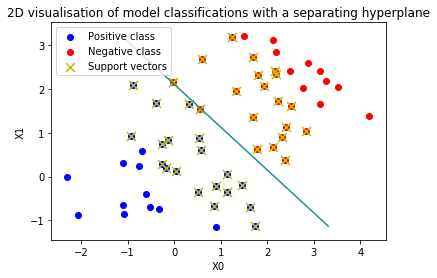

test case loss 0.11666666666666667


In [122]:
test.test_svm_qp()

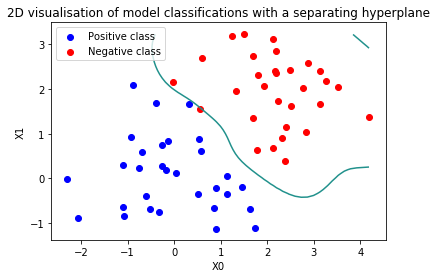

In [124]:
test.test_plot_boundary_2d()

In [229]:
class PCA():
    """
        Definition of PCA Class
        Algorithms in guide.pdf used, pg 15-17
    """

    def __init__(self, Xtrain):
        """
            Compute Principal Components
        """
        # 1. centre data
        self.Xmean = np.mean(Xtrain, axis=0)
        self.C = Xtrain - self.Xmean
        # 2. generate covariance marix
        self.C = np.cov(self.C, rowvar=False)
        # 3. calculate eigenvalues and eigenvectors
        self.D, self.U = np.linalg.eigh(self.C)

        self.idx = np.argsort(self.D)[::-1]
        # Sort the eigenvalue from high to low
        self.D = self.D[self.idx]
        # sort eigenvectors according to same index
        self.U = self.U[:, self.idx]

    def project(self, Xtest, m):
        """
            Projecting to the low-dimensional sub-space
        """
        # 1. centre data by mean of training
        Xtest = Xtest - self.Xmean
        # 2. project data to m principal components
        Z = self.U.T[range(m)].dot(Xtest.T).T
        return Z

    def denoise(self, Xtest, m):
        """
            Reconstructing projected data points in the original space
        """
        # 1. projection to the low-dimencsional sub-space
        Z = self.project(Xtest, m)
        # 2. recontruction by m dimensions
        Y = Z.dot(self.U.T[range(m)]) + self.Xmean
        return Y



In [238]:
def plot_fun(pca):
    """
    Plot function for Assignment 5
    Arranges the prinicple components plots
    """
    # intialize figure environment
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(5, 3)

    # first plot: all principle components
    f_ax1 = fig.add_subplot(gs[:, 0])
    plt.bar(range(len(pca.D)), pca.D)
    plt.xticks(range(0, len(pca.D), 50), np.append(1, np.arange(50, len(pca.D), 50)))
    plt.title('all principle components')

    plt.show()


In [239]:
pca = PCA(X_tr)

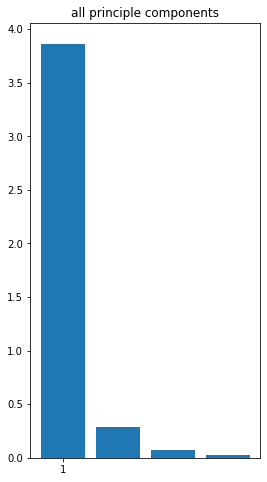

In [240]:
plot_fun(pca)

In [283]:
X_tr_test = pca.project(X_tr,2)
X_te_test = pca.project(X_te,2)

Text(0, 0.5, 'x2')

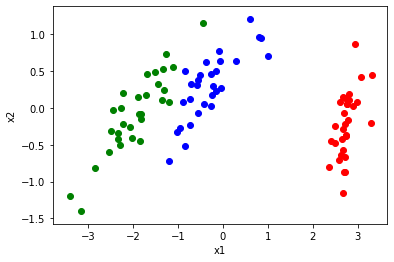

In [284]:
# Visualize data
plt.scatter(X_tr_test[y_tr == 1,0], X_tr_test[y_tr == 1,1], marker = 'o', color = 'r', label = 'setosa')
plt.scatter(X_tr_test[y_tr == 2,0], X_tr_test[y_tr == 2,1], marker = 'o', color = 'b',label = 'versicolor')
plt.scatter(X_tr_test[y_tr == 3,0], X_tr_test[y_tr == 3,1], marker = 'o', color = 'g',label = 'virginica')
plt.xlabel('x1')
plt.ylabel('x2')

In [367]:
# linear kernel
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['linear'], 'kernelparameter': [1], 'regularization': np.logspace(-2,4, 200)*len(y_tr_r) }
    cvsvm = cv(X_tr_test, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te_test)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  2%|▏         | 3/200 [00:00<00:29,  6.75it/s]

6.2


 11%|█         | 22/200 [00:02<00:17, 10.41it/s]

5.8


 20%|██        | 40/200 [00:03<00:12, 13.09it/s]

5.64


  0%|          | 0/200 [00:00<?, ?it/s]

Target class: 1.0
Loss: 5.64
Parameters: ('linear', 1, 11.74411780212962)


  0%|          | 1/200 [00:00<00:40,  4.91it/s]

6.4


 10%|█         | 21/200 [00:02<00:16, 10.64it/s]

6.28


 12%|█▏        | 23/200 [00:02<00:17, 10.00it/s]

6.24


  0%|          | 1/200 [00:00<00:21,  9.05it/s]

Target class: 2.0
Loss: 6.24
Parameters: ('linear', 1, 3.8673042338887553)
5.4


100%|██████████| 200/200 [00:14<00:00, 13.53it/s]

Target class: 3.0
Loss: 5.4
Parameters: ('linear', 1, 0.9)
accuracy: [0.6888888888888889, 0.7111111111111111, 0.6]


In [413]:
# polynomial kernel
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['polynomial'], 'kernelparameter': np.logspace(-2,2, 25), 'regularization': np.logspace(-2,4,10) }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  1%|          | 3/250 [00:00<00:48,  5.12it/s]

5.8


  4%|▍         | 10/250 [00:01<00:41,  5.77it/s]

1.36
0.0


  1%|          | 2/250 [00:00<00:19, 12.78it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('polynomial', 0.01, 10000.0)
6.4


 47%|████▋     | 117/250 [00:13<00:14,  9.04it/s]

6.24


 52%|█████▏    | 129/250 [00:14<00:12,  9.81it/s]

5.56


 54%|█████▍    | 135/250 [00:15<00:12,  8.90it/s]

4.84
4.6
1.76


 55%|█████▌    | 138/250 [00:15<00:12,  9.10it/s]

0.68


  1%|          | 2/250 [00:00<00:23, 10.60it/s]

Target class: 2.0
Loss: 0.68
Parameters: ('polynomial', 1.467799267622069, 100.0)
5.8


  2%|▏         | 6/250 [00:00<00:24,  9.83it/s]

5.56


  5%|▍         | 12/250 [00:01<00:22, 10.47it/s]

2.84


  8%|▊         | 21/250 [00:02<00:22, 10.39it/s]

1.76


 16%|█▋        | 41/250 [00:03<00:19, 10.49it/s]

0.76


 20%|██        | 51/250 [00:04<00:19, 10.40it/s]

0.4


 24%|██▍       | 61/250 [00:05<00:18, 10.43it/s]

0.32


100%|██████████| 250/250 [00:47<00:00,  5.24it/s]

Target class: 3.0
Loss: 0.32
Parameters: ('polynomial', 0.06812920690579612, 10000.0)
accuracy: [1.0, 0.5777777777777777, 0.9777777777777777]


In [411]:
# gaussian kernel
accuracy = []
for target in np.unique(Y):
    # relabel class data into 1 and -1
    # target is 1, rest -1
    y_tr_r = deepcopy(y_tr)
    y_tr_r[np.where(y_tr_r != target)] = -1
    y_tr_r[y_tr_r == target] = 1
    y_te_r = deepcopy(y_te)
    y_te_r[np.where(y_te_r != target)] = -1
    y_te_r[y_te_r == target] = 1
    
    # SVM with hard-margin
    params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,4, 25), 'regularization': np.logspace(-3,4,20)*len(y_tr_r) }
    cvsvm = cv(X_tr, y_tr_r, imp.svm_qp, params, loss_function=zero_one_loss, nfolds=5)
    print('Target class: {}'.format(target))
    print('Loss: {}'.format(cvsvm.cvloss))
    print('Parameters: {}'.format(cvsvm.__params))
    accuracy.append(np.sum(np.sign(cvsvm.predict(X_te)) == y_te_r) / len(y_te_r))
print('accuracy: {}'.format(accuracy))

  0%|          | 2/500 [00:00<01:22,  6.07it/s]

5.8


 18%|█▊        | 89/500 [00:09<00:40, 10.14it/s]

5.52
5.12
3.84


 19%|█▉        | 94/500 [00:10<00:45,  8.95it/s]

3.6


 19%|█▉        | 97/500 [00:10<01:08,  5.85it/s]

3.48


 22%|██▏       | 110/500 [00:12<00:41,  9.30it/s]

2.64
2.24


 22%|██▏       | 112/500 [00:12<00:48,  7.97it/s]

2.16
2.04


 26%|██▌       | 130/500 [00:15<00:37,  9.83it/s]

0.8
0.44
0.32


 30%|███       | 150/500 [00:17<00:36,  9.60it/s]

0.0


  0%|          | 1/500 [00:00<00:56,  8.77it/s]

Target class: 1.0
Loss: 0.0
Parameters: ('gaussian', 0.5623413251903491, 34.134211716590244)
6.4


 18%|█▊        | 90/500 [00:09<00:39, 10.36it/s]

6.28
5.44


 20%|█▉        | 98/500 [00:10<00:57,  6.98it/s]

5.32


 22%|██▏       | 109/500 [00:11<00:40,  9.61it/s]

3.0
2.76
2.12


 22%|██▏       | 112/500 [00:12<00:42,  9.21it/s]

1.96


 23%|██▎       | 115/500 [00:12<00:48,  7.89it/s]

1.92


 24%|██▍       | 120/500 [00:13<01:02,  6.06it/s]

1.84


 26%|██▌       | 129/500 [00:14<00:41,  8.87it/s]

1.04
0.92


 26%|██▋       | 132/500 [00:14<00:42,  8.72it/s]

0.72


 27%|██▋       | 134/500 [00:15<00:48,  7.58it/s]

0.6


 43%|████▎     | 214/500 [00:24<00:31,  9.15it/s]

0.48


  0%|          | 1/500 [00:00<00:49, 10.00it/s]

Target class: 2.0
Loss: 0.48
Parameters: ('gaussian', 3.1622776601683795, 2372.98580885732)
5.8


 18%|█▊        | 92/500 [00:08<00:37, 10.80it/s]

5.16


 19%|█▉        | 97/500 [00:09<00:48,  8.27it/s]

5.08


 22%|██▏       | 109/500 [00:10<00:39, 10.01it/s]

4.64
4.12
3.32


 23%|██▎       | 113/500 [00:11<00:38, 10.04it/s]

3.28
3.0


 26%|██▌       | 130/500 [00:13<00:37,  9.93it/s]

1.56
1.04


 30%|███       | 150/500 [00:15<00:35,  9.74it/s]

0.64


 34%|███▍      | 170/500 [00:17<00:34,  9.65it/s]

0.56


 47%|████▋     | 233/500 [00:24<00:25, 10.49it/s]

0.48


 51%|█████     | 255/500 [00:27<00:24, 10.07it/s]

0.4


100%|██████████| 500/500 [00:51<00:00,  9.65it/s]

Target class: 3.0
Loss: 0.4
Parameters: ('gaussian', 10.0, 5542.63389959423)
accuracy: [1.0, 0.9777777777777777, 0.9777777777777777]
